In [0]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from sklearn.model_selection import train_test_split
import shutil
import time

In [ ]:
!git clone https://github.com/prajnasb/observations


In [0]:
dataTransforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [0]:
def getTrainFilesPath(experimentsPath, dataPath, phase):
    if phase == 'train':
        fileName = 'train.csv'
    elif phase == 'test':
        fileName = 'test.csv'
    else:
        exit()
    filePath = os.path.join(experimentsPath, fileName)
    trainDf = pd.read_csv(filePath, delimiter=',')
    filesPath = []
    fontsClass = []
    for row in trainDf.iterrows():
        filesPath.append(os.path.join(dataPath, row[1]['class'], row[1]['filename']))
        fontsClass.append(row[1]['class'])
    
    return filesPath, fontsClass

In [0]:
def copyImagesToPath(filePath, fileClass, destinationDir):
    fontFolder = os.path.join(destinationDir, fileClass)
    if os.path.exists(fontFolder) == False:
        os.makedirs(fontFolder)
    
    print("File being copied from {}:{}".format(filePath, fontFolder))
    shutil.copy(filePath, fontFolder)
    

In [0]:
XTrain, yTrain = getTrainFilesPath(experimentsPath, dataPath, phase='train')
XTest, yTest = getTrainFilesPath(experimentsPath, dataPath, phase='test')

In [0]:
trainDir = os.path.join(experimentsPath, 'train')
testDir = os.path.join(experimentsPath, 'test')

if not os.path.exists(trainDir):
    os.makedirs(trainDir)

if not os.path.exists(testDir):
    os.makedirs(testDir)

In [12]:
for filePath, fontClass in zip(XTrain, yTrain):
    copyImagesToPath(filePath, fontClass, trainDir)

File being copied from observations/experiements/data/with_mask/0-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/10-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/100-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/101-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/103-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/104-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/105-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/da

In [13]:
for filePath, fontClass in zip(XTest, yTest):
    copyImagesToPath(filePath, fontClass, testDir)

File being copied from observations/experiements/data/with_mask/1-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/106-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/11-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/110-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/111-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/114-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/121-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with

In [0]:
imageDatasets = {x: datasets.ImageFolder(os.path.join(experimentsPath, x), dataTransforms[x]) for x in ['train', 'test']}

In [16]:
imageDatasets['train']

Dataset ImageFolder
    Number of datapoints: 1315
    Root location: observations/experiements/dest_folder/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [17]:
imageDatasets['test']

Dataset ImageFolder
    Number of datapoints: 194
    Root location: observations/experiements/dest_folder/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [0]:
dataloaders = {x: torch.utils.data.DataLoader(imageDatasets[x], 
                                             batch_size=16, 
                                             shuffle=True, 
                                             num_workers=4) 
               for x in ['train', 'test']}

In [19]:
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fd395b9fba8>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fd395b9fdd8>}

In [0]:
classNames = imageDatasets['train'].classes

In [21]:
classNames

['with_mask', 'without_mask']

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
device

device(type='cuda', index=0)

In [0]:
datasetSizes = {x: len(imageDatasets[x]) for x in ['train', 'test']}


In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    

In [0]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

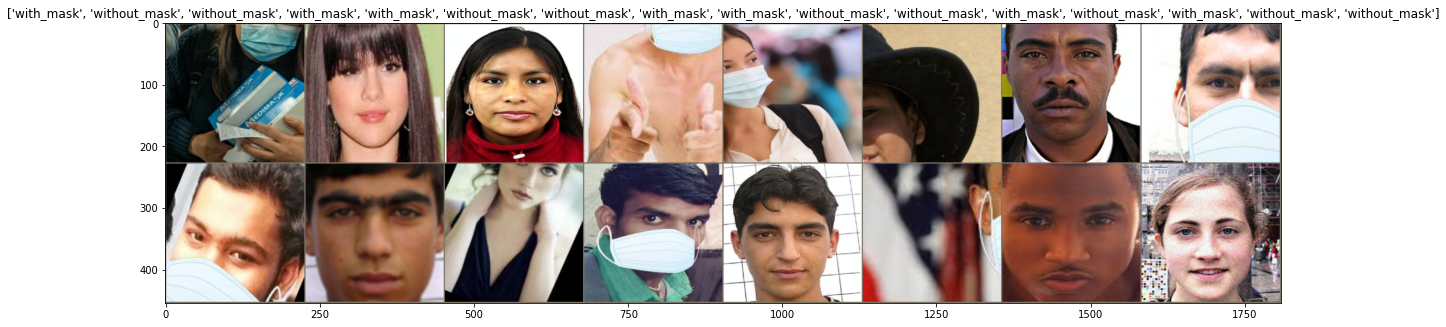

In [28]:
imshow(out, title=[classNames[x] for x in classes])

In [0]:
def trainModel(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    
    new_freeze_state = None
    prev_freeze_state = False
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / datasetSizes[phase]
            epoch_acc = running_corrects.double() / datasetSizes[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model
                

In [0]:
import ssl


In [0]:
ssl._create_default_https_context = ssl._create_unverified_context

In [0]:
model_ft = models.resnet101(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(classNames))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [39]:
model_ft = trainModel(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1981 Acc:0.9247

test Loss: 0.0079 Acc:0.9948

Epoch 1/19
----------
train Loss: 0.0972 Acc:0.9529

test Loss: 0.0044 Acc:1.0000

Epoch 2/19
----------
train Loss: 0.0780 Acc:0.9582

test Loss: 0.0031 Acc:1.0000

Epoch 3/19
----------
train Loss: 0.0867 Acc:0.9582

test Loss: 0.0663 Acc:0.9794

Epoch 4/19
----------
train Loss: 0.0625 Acc:0.9658

test Loss: 0.0022 Acc:1.0000

Epoch 5/19
----------
train Loss: 0.0862 Acc:0.9612

test Loss: 0.0114 Acc:0.9948

Epoch 6/19
----------
train Loss: 0.0772 Acc:0.9665

test Loss: 0.0008 Acc:1.0000

Epoch 7/19
----------
train Loss: 0.0764 Acc:0.9574

test Loss: 0.0006 Acc:1.0000

Epoch 8/19
----------
train Loss: 0.0780 Acc:0.9574

test Loss: 0.0006 Acc:1.0000

Epoch 9/19
----------
train Loss: 0.0607 Acc:0.9711

test Loss: 0.0004 Acc:1.0000

Epoch 10/19
----------
train Loss: 0.0825 Acc:0.9605

test Loss: 0.0006 Acc:1.0000

Epoch 11/19
----------
train Loss: 0.0753 Acc:0.9582

test Loss: 0.0003 Acc:1.0000

Epoch 12/19
----------
t

In [0]:
def visualizeModel(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds,"predicitons")
            
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
          
                print('true: {} predicted: {}'.format(classNames[labels[j]], classNames[preds[j]]))
               
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
torch.save(model_ft, 'mask1_model_resnet101.pth')

In [43]:
visualizeModel(model_ft)

tensor([1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0') predicitons
true: without_mask predicted: without_mask
true: with_mask predicted: with_mask
true: without_mask predicted: without_mask
true: without_mask predicted: without_mask
true: with_mask predicted: with_mask
true: with_mask predicted: with_mask
